In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def preprocess(image):
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5,5), 1)
    threshold = cv2.adaptiveThreshold(blurred,255,1,1,11,2)
    return threshold

def biggest_contour(contours):
    biggest = np.array([])
    max_area = 0
    for i in contours:
        area = cv2.contourArea(i)
        if area > 50:
            perimeter = cv2.arcLength(i,True)
            polygon = cv2.approxPolyDP(i, 0.02*perimeter,True )
            if (area > max_area and len(polygon) == 4):
                biggest = polygon
                max_area = area
    return biggest,max_area

def get_sudoku_cells(img):
    rows = np.vsplit(img,9)
    cells = []
    for r in rows:
        cols = np.hsplit(r,9)
        for cell in cols:
            cells.append(cell)
    return cells

def get_cell_number(cells,model):
    result = []
    for cell in cells:
        cell = np.array(cell)
        cell = cell[4:-4, 4:-4]
        cell = cv2.resize(cell,(28,28))
        cell = cell / 255
        cell = cell.reshape(1,28,28,1)
        predicted = model.predict(cell)
        cellnumber = np.argmax(predicted) # cellnumber is now a scalar, not a list
        probab = np.amax(predicted)
        if (probab > 0):
            result.append(cellnumber) # Remove [0] indexing since cellnumber is a scalar
        else:
            result.append(0)#EMPTY
    return result

def add_numbers(img,numbers):
    row_w = img.shape[1]//9
    col_w = img.shape[0]//9

    for x in range(9):
        for y in range(9):
            if numbers[(y*9)+x] != 0:

                cv2.putText(img, str(numbers[(y*9)+x]),
                               (x*row_w+int(row_w/2)-10, int((y+0.8)*col_w)), cv2.FONT_HERSHEY_COMPLEX_SMALL,
                            2, (0,0,255), 2, cv2.LINE_AA)
    return img

def draw_grid(img):
    row_w = img.shape[1]//9
    col_w = img.shape[0]//9

    for i in range(9):
        p1 = (0,col_w*i)
        p2 = (img.shape[1],col_w*i)
        p3 = (row_w*i,0)
        p4 = (row_w*i,img.shape[0])
        cv2.line(img,p1,p2,(255,255,255))
        cv2.line(img,p3,p4,(255,255,255))
    return img

def stack_images(combined,scale):
    rows = len(combined)
    cols = len(combined[0])
    rowsAvailable = isinstance(combined[0], list)
    width = combined[0][0].shape[1]
    height = combined[0][0].shape[0]

    if rowsAvailable:
        for x in range(rows):
            for y in range(cols):
                combined[x][y] = cv2.resize(combined[x][y], (0, 0), None, scale, scale)
                if len(combined[x][y].shape) == 2:
                    combined[x][y]= cv2.cvtColor( combined[x][y], cv2.COLOR_GRAY2BGR)
        imageBlank = np.zeros((height, width, 3), np.uint8)
        hor = [imageBlank]*rows
        hor_con = [imageBlank]*rows
        for x in range(rows):
            hor[x] = np.hstack(combined[x])
            hor_con[x] = np.concatenate(combined[x])
        ver = np.vstack(hor)
        ver_con = np.concatenate(hor)
    else:
        for x in range(0, rows):
            combined[x] = cv2.resize(combined[x], (0, 0), None, scale, scale)
            if len(combined[x].shape) == 2:
                combined[x] = cv2.cvtColor(combined[x], cv2.COLOR_GRAY2BGR)
        hor= np.hstack(combined)
        hor_con= np.concatenate(combined)
        ver = hor
    return ver

def wrap(Points):
    Points = Points.reshape((4, 2))
    myPointsNew = np.zeros((4, 1, 2), dtype=np.int32)
    add = Points.sum(1)
    myPointsNew[0] = Points[np.argmin(add)]
    myPointsNew[3] =Points[np.argmax(add)]
    diff = np.diff(Points, axis=1)
    myPointsNew[1] =Points[np.argmin(diff)]
    myPointsNew[2] = Points[np.argmax(diff)]
    return myPointsNew


In [2]:
def solve(bo):
    find = find_empty(bo)
    if not find:
        return True
    else:
        row, col = find
    for i in range(1,10):
        if valid(bo, i, (row, col)):
            bo[row][col] = i
            if solve(bo):
                return True
            bo[row][col] = 0
    return False

def valid(bo, num, pos):
    # Check row
    for i in range(len(bo[0])):
        if bo[pos[0]][i] == num and pos[1] != i:
            return False
    # Check column
    for i in range(len(bo)):
        if bo[i][pos[1]] == num and pos[0] != i:
            return False
    # Check box
    box_x = pos[1] // 3
    box_y = pos[0] // 3
    for i in range(box_y*3, box_y*3 + 3):
        for j in range(box_x * 3, box_x*3 + 3):
            if bo[i][j] == num and (i,j) != pos:
                return False
    return True


def find_empty(bo):
    for i in range(len(bo)):
        for j in range(len(bo[0])):
            if bo[i][j] == 0:
                return (i, j)  # row, col
    return None

1/1 [==============================] - 0s 22ms/step


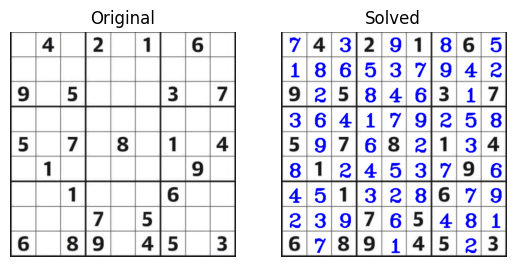

In [8]:
#from Utility_Functions import *
import cv2
import numpy as np
#import Solve_Sudoku
from tensorflow.keras.models import load_model

# Getting the Image
image_path = "/content/sudoku.jpg"
width = 450
height = 450
model = load_model("/content/model_sudoku.h5")
# Reading the image, resizing and creating a mask and getting adaptive threshold
im = cv2.imread(image_path)
im = cv2.resize(im, (width,height))
mask = np.zeros((height,width,3),np.uint8)
image_threshold = preprocess(im)
import matplotlib.pyplot as plt
#copy_1 = im.copy()
#copy_2 = im.copy()
ori = im.copy()

contours,_= cv2.findContours(image_threshold,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#cv2.drawContours(copy_1, contours, -1, (0, 255, 0), 3)
#cv2.imshow("CONTOURS",copy_1)

biggest,max_area = biggest_contour(contours)

#print(biggest)

if len(biggest) != 0:
    biggest = wrap(biggest)
    #cv2.drawContours(copy_2, biggest, -1, (0, 255, 0), 3)
    #cv2.imshow("BIGGEST CONTOURS",copy_2)
    #print(biggest)
    points_1 = np.float32(biggest)
    points_2 = np.float32([[0, 0],[width, 0], [0, height],[width, height]])
    matrix = cv2.getPerspectiveTransform(points_1, points_2)
    imgWarpColored = cv2.warpPerspective(im, matrix, (width, height))
    imgDetectedDigits = mask.copy()
    imgWarpColored = cv2.cvtColor(imgWarpColored,cv2.COLOR_BGR2GRAY)

    imgSolvedDigits = mask.copy()
    cells = get_sudoku_cells(imgWarpColored)
    # print(len(cells))
    # cv2.imshow("Sample",cells[0])

    numbers = get_cell_number(cells, model)
    #print(numbers)

    imgDetectedDigits = add_numbers(imgDetectedDigits, numbers)
    numbers = np.asarray(numbers)
    posArray = np.where(numbers > 0, 0, 1)
    #print(posArray)

    board = np.array_split(numbers,9)
    #print(board)
    try:
        solve(board)
    except:
        pass
    #print(board)
    flatList = []
    for sublist in board:
        for item in sublist:
            flatList.append(item)
    solvedNumbers =flatList*posArray
    imgSolvedDigits= add_numbers(imgSolvedDigits,solvedNumbers)

    points_1 = np.float32(biggest)
    points_2 = np.float32([[0, 0],[width, 0], [0, height],[width, height]])

    matrix = cv2.getPerspectiveTransform(points_1, points_2)
    imgInvWarpColored = im.copy()

    inv_perspective = add_numbers(im,solvedNumbers)

    fig,ax = plt.subplots(1,2)
    ax = ax.flatten()
    ax[0].imshow(ori)
    ax[0].axis('off')
    ax[0].set_title("Original")
    ax[1].imshow(im)
    ax[1].axis('off')
    ax[1].set_title("Solved")
    plt.show()
else:
    print("No Sudoku Found")


